In [9]:
import os
import cv2
from scipy.stats import skew, kurtosis
import pandas as pd
import numpy as np
CSV_PATH = r"IITKGP NEONATAL DATA\Updated_CSV.csv"
IMG_DIR = r"IITKGP NEONATAL DATA\Photos"
df = pd.read_csv(CSV_PATH)
print(df.columns)
image_data = []
labels = []
TARGET_SIZE = (256, 256)
for _, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["Image_idx"])
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, TARGET_SIZE)
        image_data.append(img)
        labels.append(row["Total bilirubin"])
    else:
        print(f"Warning: Image not found or unreadable - {img_path}")
image_data = np.array(image_data)
labels = np.array(labels)
print(f"Loaded {len(image_data)} images.")

Index(['S NO.', 'BABY NAME', 'Sex', 'CR NUMBER', 'Total bilirubin',
       'Direct bilirbin', 'Image_idx'],
      dtype='object')
Loaded 53 images.


In [10]:
from tensorflow.keras.models import load_model

model = load_model("1DCNN_model.h5")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 rgb_input (InputLayer)      [(None, 3, 16384)]           0         []                            
                                                                                                  
 hsv_input (InputLayer)      [(None, 3, 16384)]           0         []                            
                                                                                                  
 conv1d_8 (Conv1D)           (None, 3, 32)                1572896   ['rgb_input[0][0]']           
                                                                                                  
 conv1d_12 (Conv1D)          (None, 3, 32)                1572896   ['hsv_input[0][0]']           
                                                                                            

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extract_mask_hsv(img, lower_hsv, upper_hsv):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower_hsv, upper_hsv)
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    return mask

def extract_yellow_card_mask(img):
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    return extract_mask_hsv(img, lower_yellow, upper_yellow)

def extract_white_card_mask(img):
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])
    return extract_mask_hsv(img, lower_white, upper_white)

def extract_black_card_mask(img):
    lower_black = np.array([0, 0, 0])
    upper_black = np.array([180, 255, 50])
    return extract_mask_hsv(img, lower_black, upper_black)

def extract_red_card_mask(img):
    lower_red1 = np.array([0, 100, 20])
    upper_red1 = np.array([5, 255, 255])
    return extract_mask_hsv(img, lower_red1, upper_red1)


def compute_patch_means(lab_img, patch_mask):
    patch_pixels = lab_img[patch_mask > 0]
    if patch_pixels.size == 0:
        return None
    L = patch_pixels[:,0]
    A = patch_pixels[:,1]
    B = patch_pixels[:,2]
    return np.mean(L), np.mean(A), np.mean(B)

def correct_image_color_multicard(full_img, yellow_mask, white_mask, black_mask, red_mask,
                                  target_lab_yellow, target_lab_white, target_lab_black, target_lab_red):
    lab_full = cv2.cvtColor(full_img, cv2.COLOR_BGR2LAB)

    yellow_means = compute_patch_means(lab_full, yellow_mask)
    white_means = compute_patch_means(lab_full, white_mask)
    black_means = compute_patch_means(lab_full, black_mask)
    red_means = compute_patch_means(lab_full, red_mask)

    if None in (yellow_means, white_means, black_means, red_means):
        print("One or more patches not detected properly. Skipping correction.")
        return full_img

    L_y, A_y, B_y = yellow_means
    L_w, A_w, B_w = white_means
    L_b, A_b, B_b = black_means
    L_r, A_r, B_r = red_means

    delta_L = np.mean([target_lab_yellow[0] - L_y,
                       target_lab_white[0] - L_w,
                       target_lab_black[0] - L_b,
                       target_lab_red[0] - L_r ])
    delta_A = np.mean([target_lab_yellow[1] - A_y,
                       target_lab_white[1] - A_w,
                       target_lab_black[1] - A_b,
                       target_lab_red[1] - A_r])
    delta_B = np.mean([target_lab_yellow[2] - B_y,
                       target_lab_white[2] - B_w,
                       target_lab_black[2] - B_b,
                       target_lab_red[2] - B_r ])

    L_full, A_full, B_full = cv2.split(lab_full)
    L_full = np.clip(L_full + delta_L, 0, 255)
    A_full = np.clip(A_full + delta_A, 0, 255)
    B_full = np.clip(B_full + delta_B, 0, 255)

    corrected_lab = cv2.merge([L_full, A_full, B_full]).astype(np.uint8)
    corrected_bgr = cv2.cvtColor(corrected_lab, cv2.COLOR_LAB2BGR)

    return corrected_bgr
def select_chest_area_manual(image):
    """
    Manually select chest area using OpenCV ROI selector.
    """
    clone = image.copy()
    cv2.namedWindow("Select Chest Area", cv2.WINDOW_NORMAL)
    bbox = cv2.selectROI("Select Chest Area", clone, fromCenter=False, showCrosshair=True)
    cv2.destroyAllWindows()
    x, y, w, h = bbox
    if w == 0 or h == 0:
        print("No region selected. Skipping this image.")
        return None
    return image[y:y+h, x:x+w]
def extract_color_spaces(img):
    img_resized = cv2.resize(img, (128, 128))
    rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img_resized, cv2.COLOR_BGR2HSV)
    ycbcr = cv2.cvtColor(img_resized, cv2.COLOR_BGR2YCrCb) 
    lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
    
    rgb_seq = rgb.reshape(-1, 3)
    hsv_seq = hsv.reshape(-1, 3)
    ycbcr_seq = ycbcr.reshape(-1, 3)
    lab_seq = lab.reshape(-1, 3)
    
    return rgb_seq, hsv_seq, ycbcr_seq, lab_seq
def extract_skin_roi(image, roi_fraction=0.35):
    h, w = image.shape[:2]
    roi_h, roi_w = int(h * roi_fraction), int(w * roi_fraction)
    start_y = (h - roi_h) // 2
    start_x = (w - roi_w) // 2
    roi = image[start_y:start_y+roi_h, start_x:start_x+roi_w]
    return roi

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    target_lab_yellow = (242.0, 128.0, 223.0)
    target_lab_white = (255.0, 128.0, 128.0)
    target_lab_black = (0.0, 128.0, 128.0)
    target_lab_red = (136.0, 188.0, 195.0)


    yellow_mask = extract_yellow_card_mask(img)
    white_mask = extract_white_card_mask(img)
    black_mask = extract_black_card_mask(img)
    red_mask = extract_red_card_mask(img)

    corrected_img = correct_image_color_multicard(
        img, yellow_mask, white_mask, black_mask, red_mask,
        target_lab_yellow, target_lab_white, target_lab_black, target_lab_red
    )

    skin_roi = select_chest_area_manual(corrected_img)
    skin_roi=cv2.medianBlur(skin_roi,5)

    return extract_color_spaces(skin_roi)


In [13]:
processed_hsv = []
processed_ycbcr = []
processed_lab = []
processed_rgb = []
processed_labels = []

for idx, row in df.iterrows():
    img_path = os.path.join(IMG_DIR, row["Image_idx"])
    try:
        hsv, ycbcr, lab, rgb = preprocess_image(img_path)  
        processed_hsv.append(hsv)
        processed_ycbcr.append(ycbcr)
        processed_lab.append(lab)
        processed_rgb.append(rgb)
        processed_labels.append(row["Total bilirubin"]) 
    except Exception as e:
        print(f"Skipping {img_path} due to preprocessing error: {e}")
        continue

processed_hsv = np.array(processed_hsv)
processed_ycbcr = np.array(processed_ycbcr)
processed_lab = np.array(processed_lab)
processed_rgb = np.array(processed_rgb)
processed_labels = np.array(processed_labels)

print("Processed HSV shape:", processed_hsv.shape)
print("Processed labels shape:", processed_labels.shape)


One or more patches not detected properly. Skipping correction.
One or more patches not detected properly. Skipping correction.
Processed HSV shape: (53, 16384, 3)
Processed labels shape: (53,)


In [14]:
def flatten_for_scaler(data):
    return data.reshape(data.shape[0], -1)

def reshape_for_cnn(data):
    return data.reshape(data.shape[0], 3,16384)

rgb_flat = flatten_for_scaler(processed_rgb)
hsv_flat = flatten_for_scaler(processed_hsv)
ycbcr_flat = flatten_for_scaler(processed_ycbcr)
lab_flat = flatten_for_scaler(processed_lab)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

rgb_flat_scaled = scaler.fit_transform(rgb_flat)
hsv_flat_scaled = scaler.fit_transform(hsv_flat)
ycbcr_flat_scaled = scaler.fit_transform(ycbcr_flat)
lab_flat_scaled = scaler.fit_transform(lab_flat)

rgb_scaled = reshape_for_cnn(rgb_flat_scaled)
hsv_scaled = reshape_for_cnn(hsv_flat_scaled)
ycbcr_scaled = reshape_for_cnn(ycbcr_flat_scaled)
lab_scaled = reshape_for_cnn(lab_flat_scaled)

print(rgb_scaled.shape)


(53, 3, 16384)


In [15]:
test_loss, test_mae = model.evaluate([rgb_scaled, hsv_scaled], processed_labels, verbose=2)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

from sklearn.metrics import r2_score, mean_squared_error
y_pred = model.predict([rgb_scaled, hsv_scaled])
rmse = mean_squared_error(processed_labels, y_pred, squared=False)
r2 = r2_score(processed_labels, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")



2/2 - 0s - loss: 34.4625 - mae: 4.6067 - 176ms/epoch - 88ms/step
Test Loss (MSE): 34.4625
Test MAE: 4.6067
2/2 [==============================] - 0s 6ms/step
RMSE: 5.870
R²: -2.235


In [18]:
y_pred[4]

array([6.1102157], dtype=float32)

In [28]:
print("Predicted Value\t|\tReal Value")
print("-" * 30)
y_pred=y_pred.flatten()
for pred, real in zip(y_pred, processed_labels):
    print(f"{pred:.4f}\t\t|\t{real:.4f}")


Predicted Value	|	Real Value
------------------------------
23.9292		|	9.9400
5.7355		|	7.5000
8.3750		|	8.3200
4.0093		|	8.5200
6.1102		|	14.2000
7.4501		|	7.4500
9.4635		|	10.4100
17.3980		|	13.9100
5.6493		|	9.1200
9.7157		|	11.5400
15.1334		|	14.8100
10.1527		|	16.7000
8.6411		|	10.1500
10.3625		|	16.1900
9.0496		|	9.8900
2.9786		|	9.1800
11.4718		|	10.7800
4.5885		|	10.6500
21.5380		|	11.6700
16.4615		|	8.7700
13.8127		|	9.3000
10.6232		|	7.6000
16.9734		|	11.3600
20.1327		|	20.6000
28.2766		|	20.7000
20.8181		|	12.7000
9.3108		|	9.5000
9.2397		|	6.9800
2.4934		|	6.9800
3.8920		|	17.4000
3.4319		|	9.4300
12.3053		|	12.1700
9.0902		|	12.7500
6.4343		|	9.7000
2.3303		|	7.0600
15.4490		|	8.4500
17.6871		|	12.5000
10.0583		|	11.3700
4.6531		|	10.3000
16.1883		|	10.6500
14.8897		|	10.2400
19.1780		|	15.8400
15.9485		|	9.9800
4.0492		|	8.9100
9.0292		|	8.7400
11.3677		|	8.7900
26.1287		|	10.1500
3.2996		|	10.8000
12.4118		|	12.9700
18.0649		|	16.7900
22.7262		|	15.5900
8.6340		|	12.2200

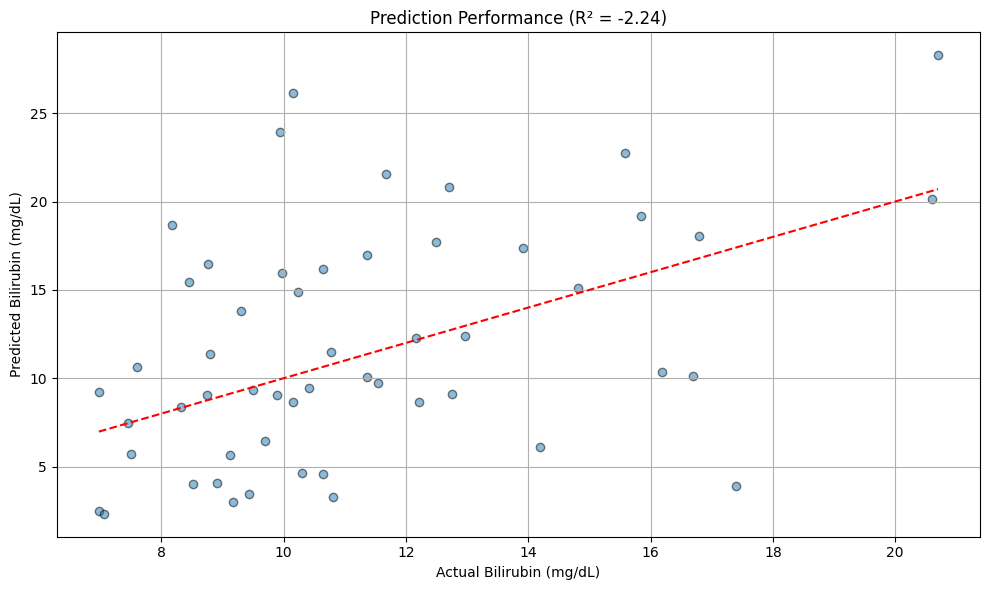

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(processed_labels, y_pred, alpha=0.5, edgecolors='k')
plt.plot([min(processed_labels), max(processed_labels)], [min(processed_labels), max(processed_labels)], 'r--')
plt.xlabel('Actual Bilirubin (mg/dL)')
plt.ylabel('Predicted Bilirubin (mg/dL)')
plt.title(f'Prediction Performance (R² = {r2:.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()
